In [2]:
#import models
import numpy as np
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
import time 

#parameters of processing
frequency = 30 #Hz
bag_file_name = '/home/hussain/me/projects/tactile/data/bags/dataset_ENVTACT_new2.bag'#'/home/hussain/me/projects/tactile/data/dataset_ENVTACT_new2.bag'
time_window_size = 6
examples_per_edge = 1

bag_file = rosbag.Bag(bag_file_name)

events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []
contact_angle = []
contact_angle_ts = []

contact_case_updated = []
contact_case_updated_ts = []

event_packet_size = []
event_packet_size_ts = []
contact_angle = []
depth = []


#generate labels
possible_angle = [0.0174532925, 0.034906585, 0.0523598776, 0.075, 0.095, 0.115, 0.135, 0.15]#
N_examples = 17
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

cases_dict = {i+1: list_of_rotations[i][:2] for i in range(len(list_of_rotations))}
cases_dict[0] = [0, 0]

In [4]:
from tqdm import tqdm
for topic, msg, t in tqdm(bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle', '/sensor_depth'])):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        contact_angle.append([msg.x, msg.y, msg.z])
        contact_angle_ts.append(t.to_nsec())
    elif topic == '/sensor_depth':
        depth.append(msg)

        # Updated contact status according to no. of events
        
            
#print(events)
bag_file.close()

580942it [01:12, 8028.88it/s] 


In [9]:
case_span = 2.66e9
find_ts_idx = lambda ts: np.searchsorted(contact_status_ts, ts)

def look_ahead_big(ts, idx_ts):
    fin_ts = ts + case_span
    fin_idx = find_ts_idx(fin_ts)
   # print(fin_idx)
    if contact_status[fin_idx]:
        #look further
        more = True
        fin_idx_ = fin_idx 
        while more:
            fin_idx_ += 1
            if fin_idx_ - fin_idx > 25:
                print('warning more than 25 idx away from init_ts + case_span')
            if contact_status[fin_idx_]:
                continue
            else:
                more = False
        #print(f'was before case ended by {fin_idx_ - fin_idx} indexes')
        fin_idx = fin_idx_ - 1
    else:
        #look backwards
        more = True
        fin_idx_ = fin_idx 
        while more:
            fin_idx_ -= 1
            if not contact_status[fin_idx_]:
                continue
            else:
                more = False
        #print(f'was ahead case ended by {fin_idx - fin_idx} indexes')
        fin_idx = fin_idx_ + 1
        
    return contact_status_ts[fin_idx]


def find_case(ts):
    idx = find_ts_idx(ts)
    best_rot_diff = 100
    best_rot_idx = 1
    i = 1
    x, y, z = contact_angle[idx]
    for rot in list_of_rotations:
        diff_vals = np.sqrt(np.power(rot[0] - x, 2) +  np.power(rot[1] - y, 2) + np.power(rot[2] - z, 2))
        if best_rot_diff > diff_vals:
            best_rot_diff = diff_vals
            best_rot_idx = i
        i = i + 1
    return best_rot_idx


i = 0 
cases_ts = []
cases_idx = []
cases = []
while i < len(contact_status):
    if contact_status[i]:
        init_ts = contact_status_ts[i]
        fin_ts = look_ahead_big(init_ts, i)
        fin_idx = find_ts_idx(fin_ts)
        case = find_case(np.mean([init_ts, fin_ts]))
        
        cases.append(case)
        cases_ts.append([init_ts, fin_ts])
        cases_idx.append([i, fin_idx])
        #print(len(cases_ts), init_ts, fin_ts, (fin_ts - init_ts)*1e-9, i, fin_idx, case, '\n')
        i = fin_idx + 1
    else:
        i += 1

In [ ]:
contact_status_mod = np.zeros(len(contact_status))
for i, case in enumerate(cases):
    contact_status_mod[cases_idx[i][0]:cases_idx[i][1] + 1] = 1

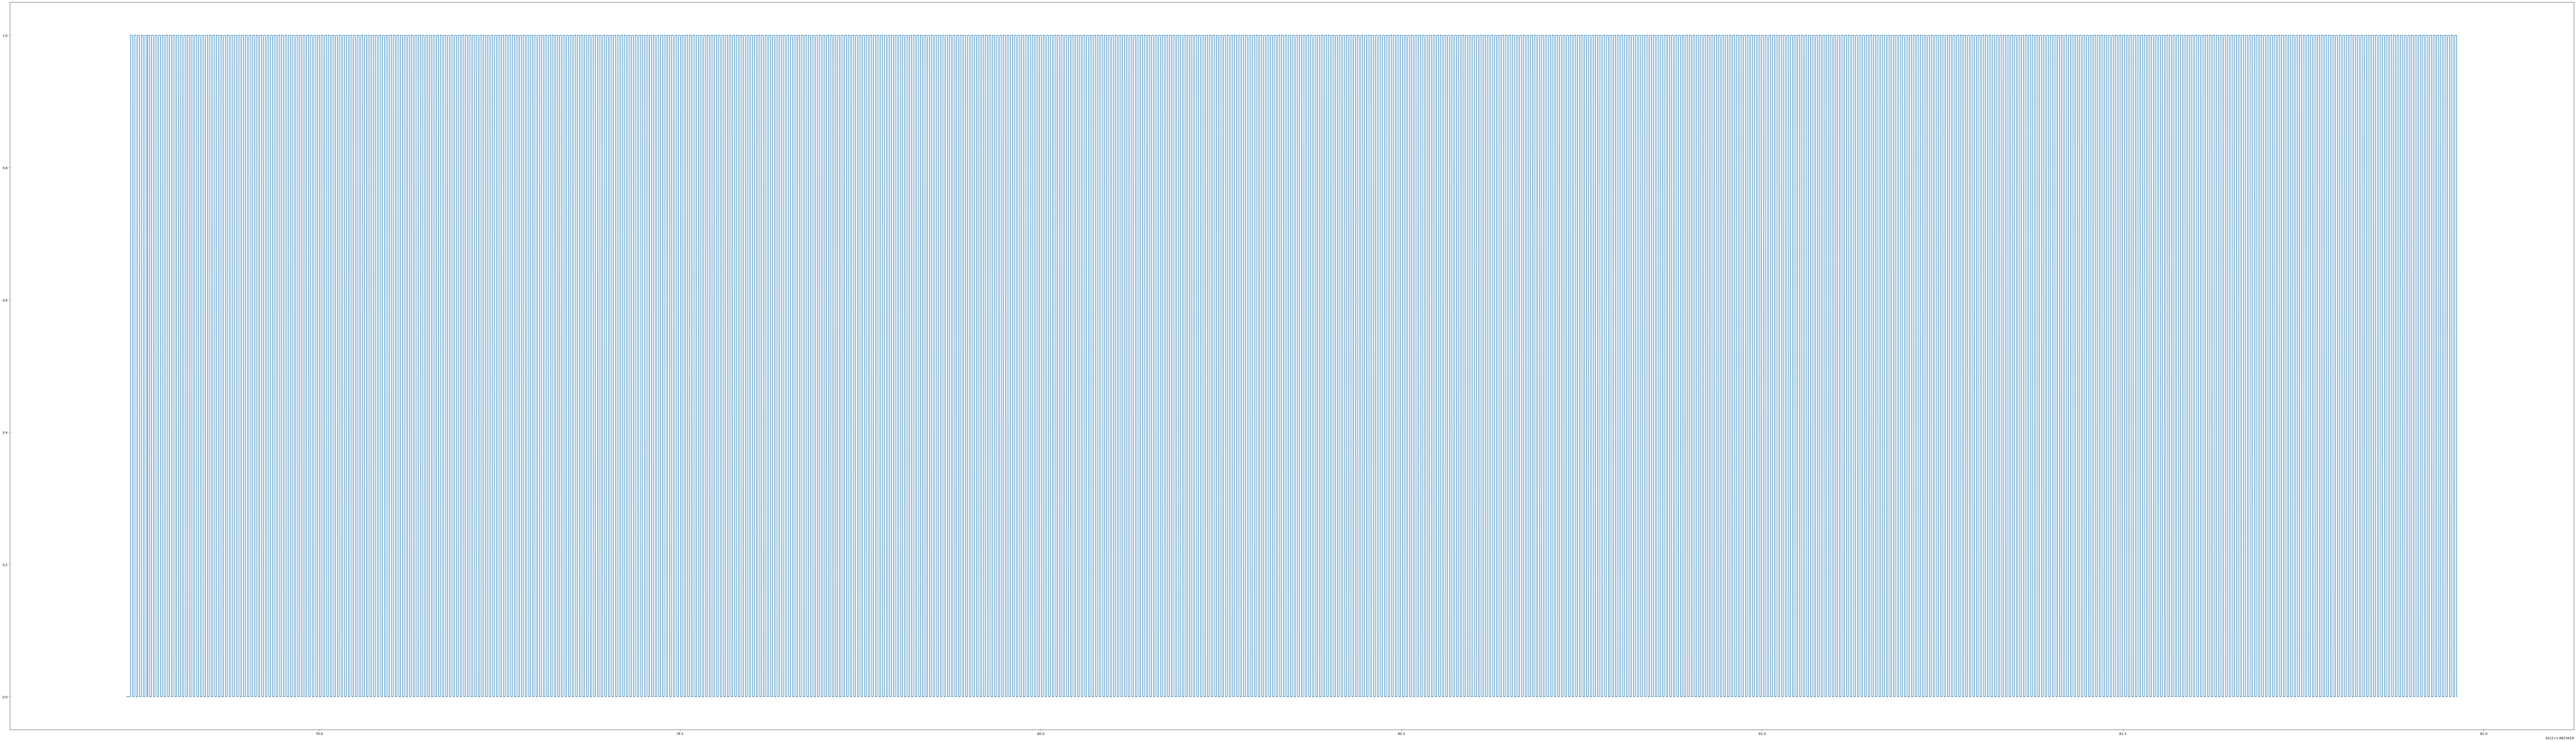

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(140, 40))
plt.plot(contact_status_ts, contact_status_mod)

In [55]:
import torch_geometric.transforms as T
import torch
from torch_geometric.nn.pool import radius_graph, knn_graph
from torch_geometric.data import Data
from torch_geometric import seed_everything
from torch_geometric.utils import to_undirected


seed_everything(0)

im_height=260
im_width=346 

def make_graph(events, contact_angle, contact_status):
    
    if len(events) == 0:
        return 
    
    coords = events[:, 0:2] - np.array([157, 122])
    coords = torch.tensor(coords.astype(np.float32))
    
    coord1, coord2 = coords.T
    
    ts = (events[:, 2]-events[0, 2])*5e-6
    
    
    coord3 = torch.tensor(ts)
    pos = torch.stack((coord1 , coord2 , coord3)).T
    
    
    r = torch.norm(coords, dim=-1)
    theta = torch.atan2(coords[:,1], coords[:,0])
    
    feature = torch.stack((r, theta, coord3))
    #feature = feature.T / torch.max(feature,dim=-1)[0]

    feature = torch.hstack((
            feature.T, # / torch.max(feature,dim=-1)[0].T,
            torch.tensor((2*events[:, 3] - 1).astype(np.float32)).reshape(-1, 1)
            ))


    edge_index = to_undirected(knn_graph(pos, 16, loop=True))
    row, col = edge_index
    
    edge_attr = feature[row, :-1] - feature[col, :-1]
    
    max_value = edge_attr.abs().max() 
    edge_attr = edge_attr / (2 * max_value) + 0.5
    
    y = torch.tensor([contact_angle[0], contact_angle[1], contact_status])

    data = Data(x=feature, edge_index=edge_index, pos=pos, y=y, edge_attr=edge_attr)
    
    return data

In [6]:
def get_angle_at_ts(timestamp):
    idx = np.searchsorted(contact_angle_ts, timestamp)
    return contact_angle[idx]

xyz = np.array(contact_angle)
euc = []
for rot in list_of_rotations:
    diff = xyz - rot
    euc.append(np.linalg.norm(diff, axis=1))
contact_case = np.argmin(np.array(euc), axis=0) + 1

def get_rot_vec_at_idx(idx):
    #print(cases_dict[best_rot_idx])
    return cases_dict[contact_case[idx]]  


def get_status_at_ts(timestamp):
    idx = np.searchsorted(contact_status_ts, timestamp)
    return contact_status_mod[idx]

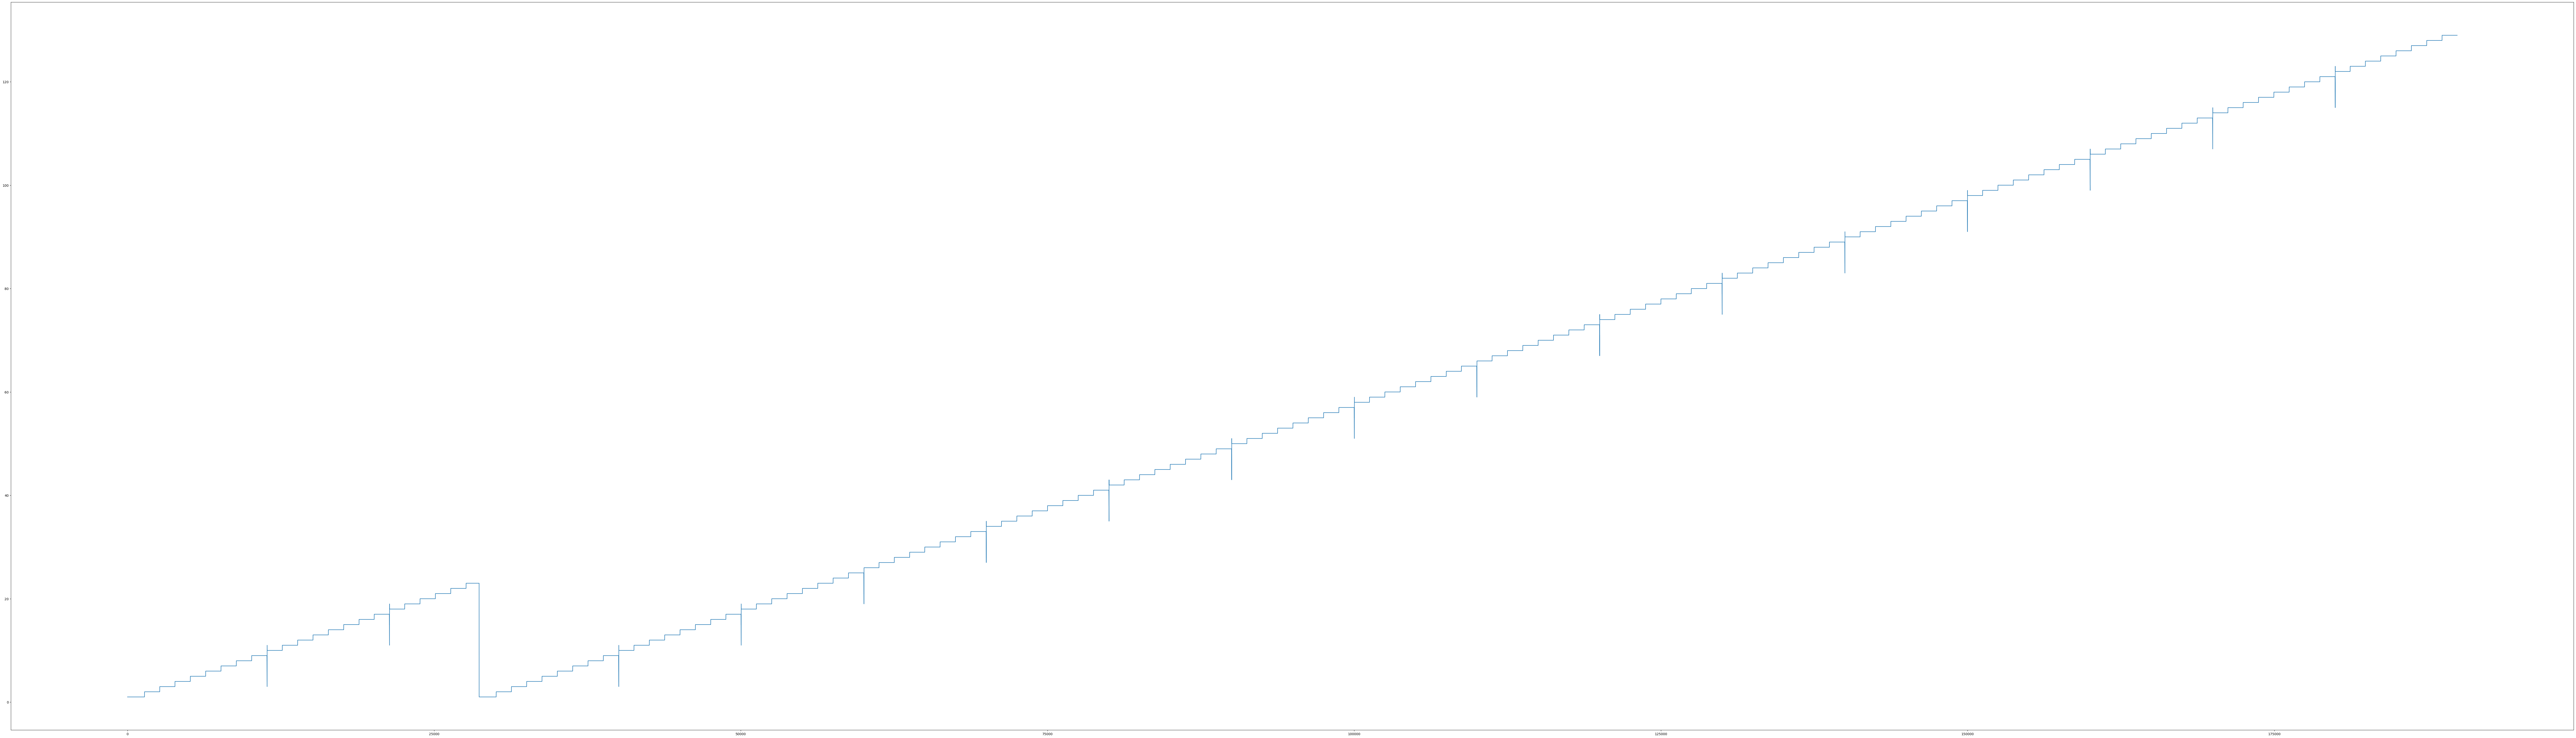

In [8]:
plt.figure(figsize=(140, 40))
plt.plot(contact_case)

In [57]:
delta_t = 0.05e9
overlap_factor = 1

def graph_gen(init_ts=0, final=np.inf):
    init_idx = 0 if init_ts==0 else np.searchsorted(ts, init_ts)
    contact_stat_window_idx = 0
    contact_angle_window_idx = 0
    
    more = True
    while more:

        fin_ts = init_ts + delta_t
        fin_idx = np.searchsorted(ts[init_idx:init_idx+3000], fin_ts) + init_idx #TODO: optimize this 

        if fin_ts >= final:
            more = False
        
        #ros_idx = np.searchsorted(contact_status_ts, init_ts + events[0, 2])
        #yield ros_idx
        if init_ts + events[0, 2] < np.min([contact_status_ts[-1], contact_angle_ts[-1]]):
            contact_stat_window_idx = np.searchsorted(
                contact_status_ts[contact_stat_window_idx:contact_stat_window_idx + 25], 
                init_ts + events[0, 2]
            ) + contact_stat_window_idx
            #contact_status[ros_idx] #contact status of window is based 

            contact_angle_window_idx = np.searchsorted(
                contact_angle_ts[contact_angle_window_idx:contact_angle_window_idx + 25], 
                init_ts + events[0, 2]
            ) + contact_angle_window_idx
            #get_rot_vec_at_ts(ros_idx)
        else:
            contact_stat_window_idx = -1
            contact_angle_window_idx = -1
            
        try:
            contact_stat_window = contact_status[contact_stat_window_idx] 
            contact_angle_window = contact_angle[contact_angle_window_idx]
        except IndexError:
            print(init_ts+events[-1, 2] > contact_status_ts[-1], contact_stat_window_idx, contact_angle_window_idx)
            

        yield make_graph(events[init_idx:fin_idx], contact_angle_window, contact_stat_window)
        
        init_ts = overlap_factor * delta_t + init_ts
        init_idx = np.searchsorted(ts[fin_idx:fin_idx+3000], init_ts) + fin_idx #TODO: optimize this 
        
        if init_idx >= len(ts):
            more = False
            


In [58]:
events = np.array(events)
ts = events[:, 2] - events[0, 2]

In [59]:
train_prop = 0.7

train_ts_range = [0, cases_ts[int(645*train_prop) + 1][-1] - events[0, 2]]
(train_ts_range[-1] - train_ts_range[0])*1e-9 / 60

37.820802501850004

In [60]:
test_ts_range = [cases_ts[int(645*train_prop) + 1][-1] - events[0, 2], events[-1, 2] - events[0, 2]]
(test_ts_range[-1] - test_ts_range[0])*1e-9 / 60

16.18285984815

In [61]:
pad = lambda x: str(x).zfill(6)
lens = []
i = 0
for graph in tqdm(graph_gen(train_ts_range[0], train_ts_range[-1])):
    if graph != None:
        torch.save(graph, '../data/dynamic/train/'+pad(i)+'.pt')
        i += 1

0it [00:00, ?it/s]

In [3]:
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
import torch
from pathlib import Path
import os

class DynamicTactileDataset(Dataset):
    
    def __init__(self, root='../data/dynamic/train/'):
        root = Path(root).resolve()
        self.graph_dirs = sorted(os.listdir(root))
        super(DynamicTactileDataset, self).__init__(root)
    
    def len(self):
        return len(self.graph_dirs)
    
    def get(self, idx):
        return torch.load(self.root / self.graph_dirs[idx])
    
    
dtd = DynamicTactileDataset()

In [4]:
dtd.get(10000).x[:, 2]

tensor([  0.0000,   6.1050,  22.0300,  28.5050,  31.2400,  43.7800,  44.3550,
         65.4450,  70.9050,  83.8700,  85.6700,  86.3900,  90.0550,  99.6800,
        105.5800, 114.8950, 115.5150, 139.3000, 146.5400, 156.6700, 162.4600,
        162.9500, 168.3100, 173.6250, 185.9350, 198.7150, 205.9100, 217.2350,
        217.3250, 228.3050, 241.3150, 243.3200, 245.8500], dtype=torch.float64)

In [5]:
loader = DataLoader(dtd, batch_size=10)

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x.float(), edge_index, edge_weight.float())
        h = F.relu(h)
        h = self.linear(h)
        return h
    
from tqdm.auto import tqdm


from torch_geometric.nn import GCNConv, global_mean_pool, voxel_grid, max_pool, SplineConv, max_pool_x
from torch.nn.functional import elu, dropout

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = SplineConv(4, 32, dim=3, kernel_size=5)
        self.bn1 = torch.nn.BatchNorm1d(32)
        #mp1 = MaxPooling(3*[3], transform=delta_theta)
        self.conv2 = SplineConv(32, 64, dim=3, kernel_size=5)
        self.bn2 = torch.nn.BatchNorm1d(64)
    
        #fc1 = torch.nn.Linear(64, 64)
        self.fc1 = torch.nn.Linear(64*64, 16)
        self.fc2 = torch.nn.Linear(16, 3)
    

    def forward(self, data):
        
        data.x = elu(self.conv1(data.x.float(), data.edge_index, edge_attr=data.edge_attr.float()))
        data.x = self.bn1(data.x)
        
        data.x = elu(self.conv2(data.x, data.edge_index, edge_attr=data.edge_attr))
        cluster = voxel_grid(data.pos, batch=data.batch, size=0.3)
        x,_ = max_pool_x(cluster, data.x, batch=data.batch, size=64)
        x = x.view(-1, self.fc1.weight.size(1))

        x = elu(self.fc1(x))
        x = dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        
        return x

model = Model().cuda()#RecurrentGCN(node_features=4, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50), desc='training', unit='epoch'):
    epoch_loss = 0
    lr = optimizer.param_groups[0]['lr']
    with tqdm(loader, unit="batch") as tepoch:
        for time, snapshot in enumerate(tepoch):
            if snapshot.x == None:
                continue
            y_hat = model(snapshot.cuda())#model(snapshot.x, snapshot.edge_index, snapshot.edge_attr[:, 0])
            cost = torch.mean((y_hat-snapshot.y)**2)
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += cost.detach().item()
            tepoch.set_postfix({
                'train_loss': np.sqrt(epoch_loss / (i + 1)), 
                #'train_loss_degrees': epoch_loss / (i + 1) * 180/np.pi,
                'lr': lr
            })


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
snapshot

In [ ]:
data.get(100)

In [ ]:
torch.load('../data/dynamic/train/010201.pt')

In [ ]:
plt.hist(lens, bins=50)